In [1]:
"""
Author: Jakub Stavina, UID: 10832596
Course: PHYS30302 General Physics Skills
Date: March 22, 2024
Description: This program simulates the 2D Rayleigh-Benard convection using lattice Boltzmann method. 
"""

import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

# PHYSICAL PARAMETERS
rho0 = 1                   # INITIAL FLUID DENSITY
T0 = 1                     # INITIAL FLUID TEMPERATURE
Ttop = 0.5                 # TOP TEMPERATURE
Tbot = 1.5                 # BOTTOM TEMPERATURE
g_alpha = .015             # GRAVITATIONAL ACCELERATION * THERMAL EXPANSION COEF. - g * alpha
kappa = 0.002              # THERMAL CONDUCTIVITY - kappa
nu = 0.5/3                 # KINEMATIC VISCOSITY - nu 

# COMMON CONSTANTS
k1 = 1 / (3*nu + 0.5)      
k2 = 1 - k1
k3 = 1 - 0.5*k1
l1 = 1 / (3*kappa + 0.5)
l2 = 1 - l1

# LATTICE PARAMETERS
Nx = 400  
Ny = 100
Nt = 20000

# LATTICE VELOCITIES
e = np.array(((0, 0), (1, 0), (0, 1), (-1, 0), (0, -1), (1, 1), (-1, 1), (-1, -1), (1, -1))).T

# LATTICE WEIGHTS
w = np.array((4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36))

# OPPOSITE LATTICE INDEX i-bar
i_bar = [0, 3, 4, 1, 2, 7, 8, 5, 6]

# RAYLEIGH NUMBER
print("Ra =", g_alpha*abs(Ttop - Tbot)*(Ny**3) / (kappa*nu))

# SPECIFY WALLS
wall = np.full((Nx, Ny), False)
wall[: , 0 ] = True
wall[: , -1] = True

idx = np.empty((9, Nx, Ny), dtype=bool)
    
Twall = np.full((Nx, Ny), 0.)
Twall[: , 0 ] = Tbot
Twall[: , -1] = Ttop

Tboundary = np.empty((9, 2*Nx))

for i in range(9):
    idx[i] = np.roll(wall, e[:,i], axis=(0,1))
    Tboundary[i] = np.roll(Twall, e[:, i], axis=(0,1))[idx[i]]
    

Ra = 45000000.0


In [2]:
# EQUILIBRIUM DISTRIBUTIONS OF f AND g

def f_eq(rho, u):
    ei_dot_u = np.einsum('dxy,di->xyi', u, e)
    return np.einsum('xy,i->xyi', rho, w) * (1 + 3 * ei_dot_u + 4.5 * (ei_dot_u**2) - 1.5 * np.einsum('dxy->xy', u*u)[:,:,np.newaxis])

def g_eq(T, u):
    ei_dot_u = np.einsum('dxy,di->xyi', u, e)
    return np.einsum('xy,i->xyi', T, w) * (1 + 3 * ei_dot_u)


# INITIALIZE ARRAYS, APPLY INITIAL CONDITIONS
f = f_eq(np.full((Nx, Ny), rho0), np.zeros((2, Nx, Ny)))
f[wall] = np.nan

rho = np.sum(f, axis=2)
u = (np.einsum('xyi,di->dxy', f, e)) / rho

dT = np.fromfunction(lambda x, y: 0.5e-2*np.sin(x/(Nx-1.0)*12*np.pi)*np.sin((y/Ny)*np.pi), (Nx, Ny))

g = g_eq(np.full((Nx, Ny), T0 + dT), u)
f[wall] = np.nan

T = np.sum(g, axis=2)

1 : i = 0 : T MIN/MAX: 0.8330983776074723 1.166797276423986 0.9999999999999998


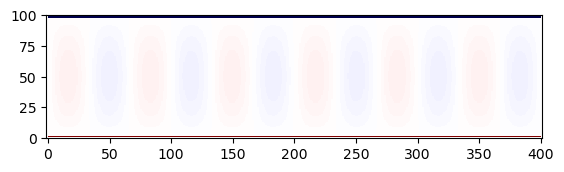

2 : i = 2000 : T MIN/MAX: 0.5324799823323098 1.4678478853405403 1.0005671294124596


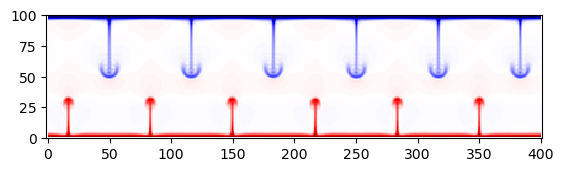

3 : i = 4000 : T MIN/MAX: 0.5314479786864222 1.456123480481737 0.9989029368150872


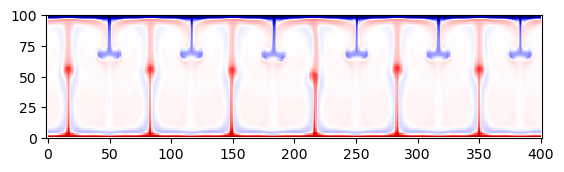

4 : i = 6000 : T MIN/MAX: 0.5307246336574628 1.4407056016515045 0.9975277563907384


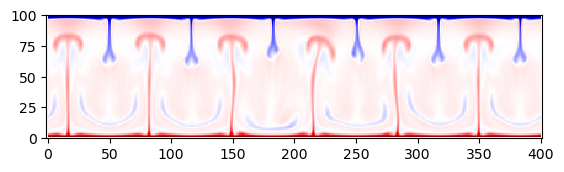

5 : i = 8000 : T MIN/MAX: 0.5245816662490412 1.4594056892295115 0.99643581530836


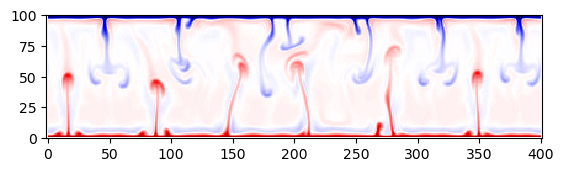

6 : i = 10000 : T MIN/MAX: 0.5293967730415522 1.444522389854323 0.9964364647033366


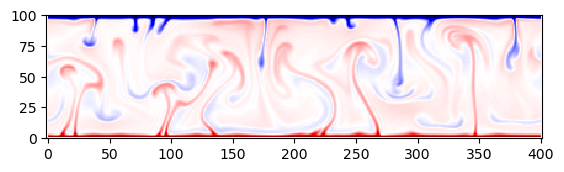

7 : i = 12000 : T MIN/MAX: 0.5496779137625866 1.4580564225080184 0.9967702267957572


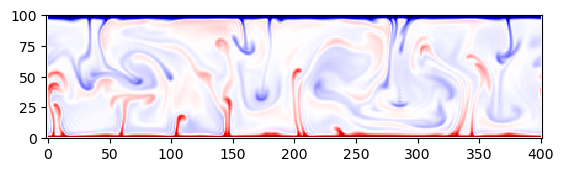

8 : i = 14000 : T MIN/MAX: 0.5416436032584737 1.4669033154192037 0.9969795236796322


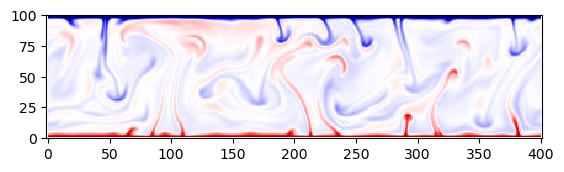

9 : i = 16000 : T MIN/MAX: 0.5433378298592865 1.4689956648936535 0.9972386625434722


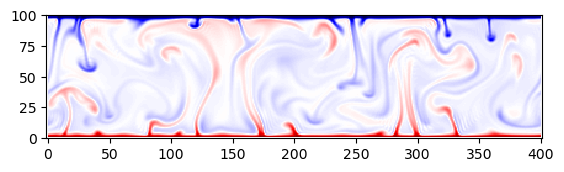

10 : i = 18000 : T MIN/MAX: 0.5304520702093326 1.460709224970438 0.9975642898690081


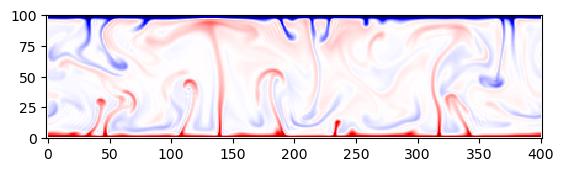

Elapsed time: 391.45429024999976


In [3]:
start = timer()

for _ in range(Nt):
    
    g_star = l1*g_eq(T, u) + l2*g
    
    for i in range(9):
        g[:,:,i] = np.roll(g_star[:,:,i], e[:,i], axis=(0,1))
        g[idx[i],i] = -g_star[idx[i], i_bar[i]] + 2*w[i_bar[i]]*Tboundary[i]
    
    T = np.sum(g, axis=2)
    T0 = np.nanmean(T)
    
    F = rho0*(T - T0)*g_alpha
    
    ei_dot_u = np.einsum('dxy,di->xyi', u, e)
    S = 3*k3*np.einsum('xy,i->xyi', F, w)*((1 + 3*ei_dot_u)*e[1] - u[1][:,:,np.newaxis])
    
    f_star = k1*f_eq(rho, u) + k2*f + S
    
    for i in range(9):
        f[:,:,i] = np.roll(f_star[:,:,i], e[:,i], axis=(0,1))
        f[idx[i],i] = f_star[idx[i],i_bar[i]]     
    
    rho = np.sum(f, axis=2)
    u = np.einsum('xyi,di->dxy', f, e) 
    u[1] += 0.5*F
    u /= rho
    
    if _%(Nt/10)==0:
        print(1+int(10*_/Nt), ": i =", _, ": T MIN/MAX:", np.nanmin(T), np.nanmax(T), T0)
        
        plt.figure(figsize=(6.4, 6.4*Ny/Nx))
        plt.pcolormesh(T.transpose(), cmap='seismic')
        plt.axis("equal")
        plt.show()
    
end = timer()

print(f'Elapsed time: {end - start}')

|u| MIN/MAX: 7.428594439380126e-05 0.15491215576478135
rho MIN/MAX: 0.9356254790483751 1.0510816036955164
T   MIN/MAX: 0.5344829745136259 1.4598573496668237


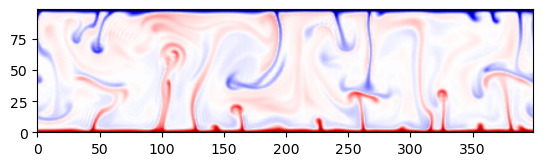

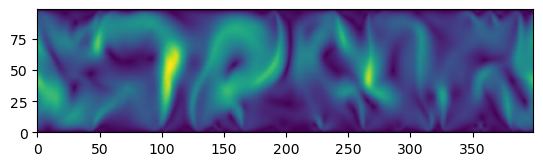

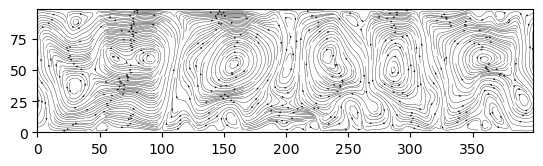

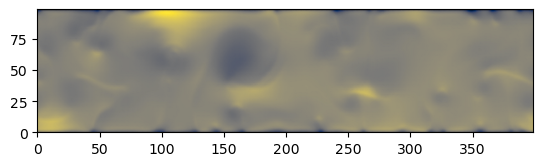

In [8]:
%matplotlib inline

velocity = np.sqrt(u[0]**2+u[1]**2)
Y, X = np.mgrid[0:Ny:1, 0:Nx:1]

print("|u| MIN/MAX:", np.nanmin(velocity), np.nanmax(velocity))
print("rho MIN/MAX:", np.nanmin(rho), np.nanmax(rho))
print("T   MIN/MAX:", np.nanmin(T), np.nanmax(T))

plt.figure(figsize=(6.4, 6.4*Ny/Nx))
#plt.title("Temperature", fontsize=16)
plt.pcolormesh(T.transpose(), cmap='seismic', shading="gouraud")
plt.axis("equal")
plt.savefig("Temperature.png", dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.4, 6.4*Ny/Nx))
#plt.title("Velocity", fontsize=16)
plt.pcolormesh(velocity.transpose(), cmap='viridis', shading="gouraud")
plt.axis("equal")
plt.savefig("Velocity.png", dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.4, 6.4*Ny/Nx))
#plt.title("Streamlines", fontsize=16)
plt.streamplot(X, Y, u[0].T, u[1].T, linewidth = 0.25, density = 5, arrowsize = 0.25, color="k")
plt.axis("equal")
plt.savefig("Streamlines.png", dpi=400, bbox_inches='tight')
plt.show()

plt.figure(figsize=(6.4, 6.4*Ny/Nx))
#plt.title("Density", fontsize=16)
plt.pcolormesh(rho.transpose(), cmap='cividis', shading="gouraud")
plt.axis("equal")
plt.savefig("Density.png", dpi=400, bbox_inches='tight')
plt.show()